<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/Visualizing_Function_Space_Similarity_MediumCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Imports and Installations

In [ ]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [ ]:
%%capture
!pip install wandb

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Get Trained Models

(For now I am using models trained from SmallCNN.)

In [ ]:
ROOT_PATH = 'gdrive/My Drive/LossLandscape/'
## MediumCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = ROOT_PATH+'MediumCNN_CheckpointID_1/'
## MediumCNN models with different initialization(total 10 models)
INDEPENDENT_MODEL_PATH = ROOT_PATH+'MediumIndependentSolutions/'
## MediumCNN models with different initialization(total 3 models) with all checkpoints saved
INDEPENDENT_MODEL_PATH_tsne = ROOT_PATH+'MediumIndependentSolutions_tsne/'

In [ ]:
same_model_ckpts = os.listdir(MODEL_PATH)
independent_models = os.listdir(INDEPENDENT_MODEL_PATH)
independent_models_tsne = os.listdir(INDEPENDENT_MODEL_PATH_tsne)


print(len(same_model_ckpts))
print(len(independent_models))
print(len(independent_models_tsne))

40
10
3


In [ ]:
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [ ]:
same_model_ckpts = sorted_nicely(same_model_ckpts)
same_model_ckpts[:5]

['medium_cnn_checkpoint_0.h5',
 'medium_cnn_checkpoint_1.h5',
 'medium_cnn_checkpoint_2.h5',
 'medium_cnn_checkpoint_3.h5',
 'medium_cnn_checkpoint_4.h5']

In [ ]:
independent_models = sorted_nicely(independent_models)
independent_models[:5]

['mediumcnn_independent_model_0.h5',
 'mediumcnn_independent_model_1.h5',
 'mediumcnn_independent_model_2.h5',
 'mediumcnn_independent_model_3.h5',
 'mediumcnn_independent_model_4.h5']

# Get Dataset and Prepare

#### CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


#### Dataloader

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 32

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#   Similarity of Functions Within Initialized Trajectories

## Disagreement of predictions 

(Refer figure 2(b) from paper)

In [ ]:
# Given model and test data, return true_labels and predictions.
def evaluate(test_dataloader, model):
  true_labels = []
  pred_labels = []
  
  for imgs, labels in iter(test_dataloader):
    preds = model.predict(imgs)
    
    true_labels.extend(labels)
    pred_labels.extend(np.argmax(preds, axis=1))

  return np.array(true_labels), np.array(pred_labels)

In [ ]:
predictions = []
for i in tqdm_notebook(range(40)):
  # load model
  model = tf.keras.models.load_model(MODEL_PATH+same_model_ckpts[i])
  # get predictions for model
  _, preds = evaluate(testloader, model)

  predictions.append(preds)

In [ ]:
empty_arr = np.zeros(shape=(40,40))

for i in tqdm_notebook(range(40)):
  preds1 = predictions[i]
  for j in range(i, 40):
    preds2 = predictions[j]
    
    # compute dissimilarity
    dissimilarity_score = 1-np.sum(np.equal(preds1, preds2))/10000 
    
    empty_arr[i][j] = dissimilarity_score
    if i is not j:
      empty_arr[j][i] = dissimilarity_score

dissimilarity_coeff = empty_arr[::-1]

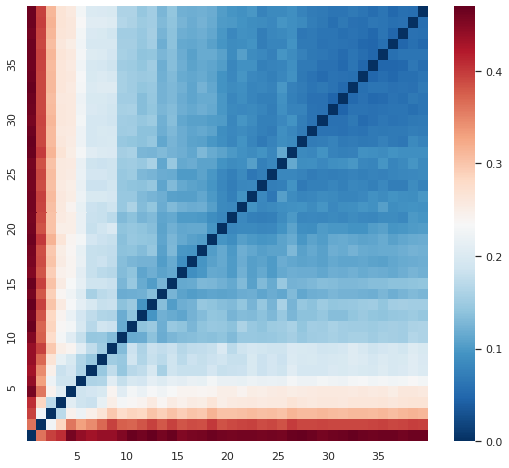

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(dissimilarity_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);

plt.savefig('prediction_disagreement.png')

## Cosine Similarity of weights

(Refer figure 2(a) from paper)

In [ ]:
# Get the weights of the input model. 
def get_model_weights(model):
  model_weights = []
  # iterate through model layers.
  for layer in model.layers:
    # grab weights of that layer
    weights = layer.get_weights() # list
    # check if layer got triainable weights
    if len(weights)==0:
      continue

    # discard biases term, wrap with ndarray, flatten weights
    model_weights.extend(np.array(weights[0]).flatten())

  return np.array(model_weights)

In [ ]:
weights_of_models = []
for i in tqdm_notebook(range(40)):
  # load model
  model = tf.keras.models.load_model(MODEL_PATH+same_model_ckpts[i])
  # get predictions for model
  weights = get_model_weights(model)

  weights_of_models.append(weights)

In [ ]:
empty_arr = np.zeros(shape=(40,40))

for i in tqdm_notebook(range(40)):
  weights1 = weights_of_models[i]
  for j in range(i, 40):
    weights2 = weights_of_models[j]
    
    # compute cosine similarity of weights
    cos_sim = np.dot(weights1, weights2)/(norm(weights1)*norm(weights2))
    
    empty_arr[i][j] = cos_sim
    if i is not j:
      empty_arr[j][i] = cos_sim

cos_sim_coeff = empty_arr[::-1]

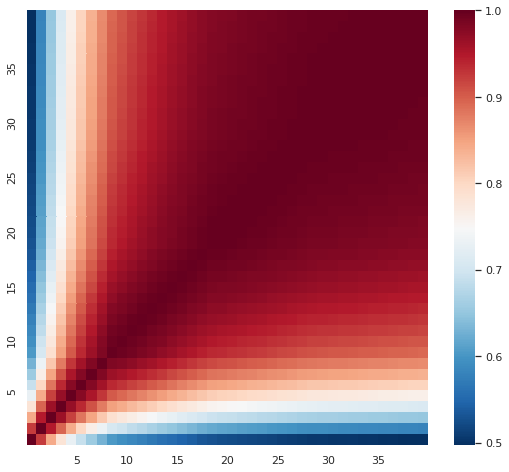

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(cos_sim_coeff, cmap='RdBu_r');
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35]);
plt.yticks([5,10,15,20,25,30,35],[35,30,25,20,15,10,5]);

plt.savefig('functional_similarity.png')

In [ ]:
wandb.init(entity='authors', project='loss-landscape', id='medium_cnn_same_model_investigations')
wandb.log({'prediction_disagreement': wandb.Image('prediction_disagreement.png')})
wandb.log({'functional_similarity': wandb.Image('functional_similarity.png')})

# Similarity of Functions Across Randomly Initialized Trajectories

## Disagreement of predictions

(Refer figure 3(a) from paper)

In [ ]:
predictions = []
for i in tqdm_notebook(range(10)):
  # load model
  model = tf.keras.models.load_model(INDEPENDENT_MODEL_PATH+independent_models[i])
  # get predictions for model
  _, preds = evaluate(testloader, model)

  predictions.append(preds)

In [ ]:
empty_arr = np.zeros(shape=(10,10))

for i in tqdm_notebook(range(10)):
  preds1 = predictions[i]
  for j in range(i, 10):
    preds2 = predictions[j]
    
    # compute dissimilarity
    dissimilarity_score = 1-np.sum(np.equal(preds1, preds2))/10000 
    
    empty_arr[i][j] = dissimilarity_score
    if i is not j:
      empty_arr[j][i] = dissimilarity_score

dissimilarity_coeff = empty_arr[::-1]

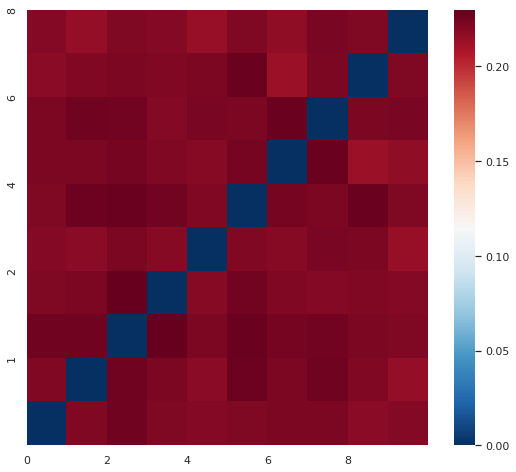

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(dissimilarity_coeff, cmap='RdBu_r');
plt.xticks([0,2,4,6,8],[0,2,4,6,8]);
plt.yticks([0,2,4,6,8],[8,6,4,2,1]);

plt.savefig('independent_prediction_disagreement.png')

## Cosine Similarity of weights

(Refer figure 3(a) from paper)

In [ ]:
# Get the weights of the input model. 
def get_model_weights(model):
  model_weights = []
  # iterate through model layers.
  for layer in model.layers:
    # grab weights of that layer
    weights = layer.get_weights() # list
    # check if layer got triainable weights
    if len(weights)==0:
      continue

    # discard biases term, wrap with ndarray, flatten weights
    model_weights.extend(np.array(weights[0]).flatten())

  return np.array(model_weights)

In [ ]:
weights_of_models = []
for i in tqdm_notebook(range(10)):
  # load model
  model = tf.keras.models.load_model(INDEPENDENT_MODEL_PATH+independent_models[i])
  # get predictions for model
  weights = get_model_weights(model)

  weights_of_models.append(weights)

In [ ]:
empty_arr = np.zeros(shape=(10,10))

for i in tqdm_notebook(range(10)):
  weights1 = weights_of_models[i]
  for j in range(i, 10):
    weights2 = weights_of_models[j]
    
    # compute cosine similarity of weights
    cos_sim = np.dot(weights1, weights2)/(norm(weights1)*norm(weights2))
    
    empty_arr[i][j] = cos_sim
    if i is not j:
      empty_arr[j][i] = cos_sim

cos_sim_coeff = empty_arr[::-1]

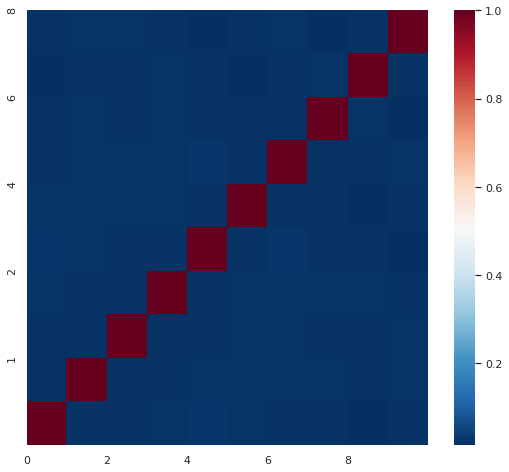

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(cos_sim_coeff, cmap='RdBu_r');
plt.xticks([0,2,4,6,8],[0,2,4,6,8]);
plt.yticks([0,2,4,6,8],[8,6,4,2,1]);

plt.savefig('independent_functional_similarity.png')

In [ ]:
wandb.init(entity='authors', project='loss-landscape', id='medium_cnn_independent_model_investigations')
wandb.log({'independent_prediction_disagreement': wandb.Image('independent_prediction_disagreement.png')})
wandb.log({'independent_functional_similarity': wandb.Image('independent_functional_similarity.png')})

# Investigating Loss Landscape

In [ ]:
test_tsne_ds = testloader.unbatch().take(1024).batch(BATCH_SIZE)

In [ ]:
# Given model and test data, return true_labels and predictions.
def evaluate_tsne(test_dataloader, model):
  true_labels = []
  pred_labels = []
  
  for imgs, labels in iter(test_dataloader):
    preds = model.predict(imgs)
    
    true_labels.extend(labels)
    pred_labels.extend(preds.flatten()) ## change here 

  return np.array(true_labels), np.array(pred_labels)

In [ ]:
predictions_for_tsne = {}

for i in tqdm_notebook(range(3)):
  subdir = independent_models_tsne[i]
  model_files = os.listdir(INDEPENDENT_MODEL_PATH_tsne+subdir)
  model_files = sorted_nicely(model_files)
  predictions = []
  for model_file in model_files:
    try:
      model = tf.keras.models.load_model(INDEPENDENT_MODEL_PATH_tsne+subdir+'/'+model_file)
    except:
      continue

    _, preds = evaluate_tsne(test_tsne_ds, model)

    predictions.append(preds)
  predictions_for_tsne['init_{}'.format(i+1)] = predictions

In [ ]:
## initialize tsne object
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=270,
            n_iter=2000)

In [ ]:
## compute tsne for all three inits and there checkpoints
tsne_vals = {}

for key, values in tqdm_notebook(predictions_for_tsne.items()):
  tsne_embedded = tsne.fit_transform(values)

  tsne_vals[key] = tsne_embedded

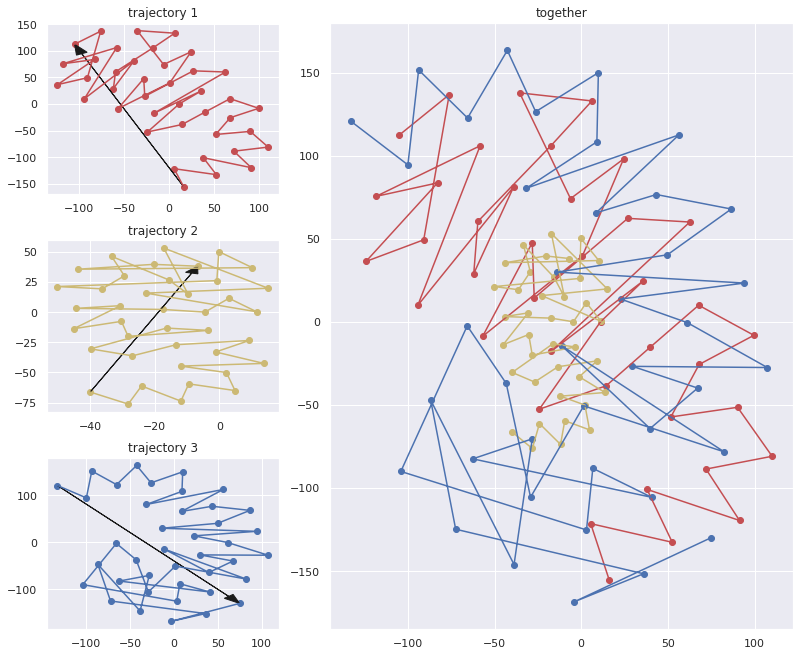

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(11,9))

gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, :1])
ax1.set_title('trajectory 1')
ax1.scatter(tsne_vals['init_1'][:,0], tsne_vals['init_1'][:,1], c="r");
ax1.plot(tsne_vals['init_1'][:,0], tsne_vals['init_1'][:,1], '-', c="r");
x, y = tsne_vals['init_1'][:,0][0], tsne_vals['init_1'][:,1][0]
x_, y_ =  tsne_vals['init_1'][:,0][-1], tsne_vals['init_1'][:,1][-1]
ax1.arrow(x=x, y=y, dx=-(x-x_), dy=-(y-y_),
          ls='-', color='k', length_includes_head=True, head_width=13)

ax2 = fig.add_subplot(gs[1, :1])
ax2.set_title('trajectory 2')
ax2.scatter(tsne_vals['init_2'][:,0], tsne_vals['init_2'][:,1], c="y");
ax2.plot(tsne_vals['init_2'][:,0], tsne_vals['init_2'][:,1], '-', c="y");
x, y = tsne_vals['init_2'][:,0][0], tsne_vals['init_2'][:,1][0]
x_, y_ =  tsne_vals['init_2'][:,0][-1], tsne_vals['init_2'][:,1][-1]
ax2.arrow(x=x, y=y, dx=-(x-x_), dy=-(y-y_),
          ls='-', color='k', length_includes_head=True, head_width=4)

ax3 = fig.add_subplot(gs[-1, :1])
ax3.set_title('trajectory 3')
ax3.scatter(tsne_vals['init_3'][:,0], tsne_vals['init_3'][:,1], c="b");
ax3.plot(tsne_vals['init_3'][:,0], tsne_vals['init_3'][:,1], '-', c="b");
x, y = tsne_vals['init_3'][:,0][0], tsne_vals['init_3'][:,1][0]
x_, y_ =  tsne_vals['init_3'][:,0][-1], tsne_vals['init_3'][:,1][-1]
ax3.arrow(x=x, y=y, dx=-(x-x_), dy=-(y-y_),
          ls='-', color='k', length_includes_head=True, head_width=13)

ax4 = fig.add_subplot(gs[:, 1:])
ax4.set_title('together')
ax4.scatter(tsne_vals['init_1'][:,0], tsne_vals['init_1'][:,1], c="r");
ax4.plot(tsne_vals['init_1'][:,0], tsne_vals['init_1'][:,1], '-', c="r");
ax4.scatter(tsne_vals['init_2'][:,0], tsne_vals['init_2'][:,1], c="y");
ax4.plot(tsne_vals['init_2'][:,0], tsne_vals['init_2'][:,1], '-', c="y");
ax4.scatter(tsne_vals['init_3'][:,0], tsne_vals['init_3'][:,1], c="b");
ax4.plot(tsne_vals['init_3'][:,0], tsne_vals['init_3'][:,1], '-', c="b");

plt.savefig('loss_landscape_2d.png')

> The plots on the right are individual trajectories for each uniquely initialized models. The arrow connects the first and the last point in the 2d projection. 

> The plot on the right shows the trajectories in the same plane. Even though they start from different points on the space there loss valley overlaps to some extent. From our experiment, we see that even though the models are initialized differently they converged in the same valley(local minima). Since they didn't settle in one place we can clearly say that the loss landscape is non-convex with many sub local valleys. 

> Through what we implemented, we can say that the models take different trajectories as claimed by author. But they might not end up at different valleys like they showed. However we have some unclarity about t-SNE. So not discarding authors claim completely. 

##### What if we take 3 components for the t-SNE dimensional reduction?

In [ ]:
## initialize tsne object
tsne = TSNE(n_components=3,
            perplexity=30,
            learning_rate=270,
            n_iter=2000)

In [ ]:
## compute tsne for all three inits and there checkpoints
tsne_vals = {}

for key, values in tqdm_notebook(predictions_for_tsne.items()):
  tsne_embedded = tsne.fit_transform(values)

  tsne_vals[key] = tsne_embedded

In [ ]:
xs, ys, zs = tsne_vals['init_1'][:,0], tsne_vals['init_1'][:,1], tsne_vals['init_1'][:,2]

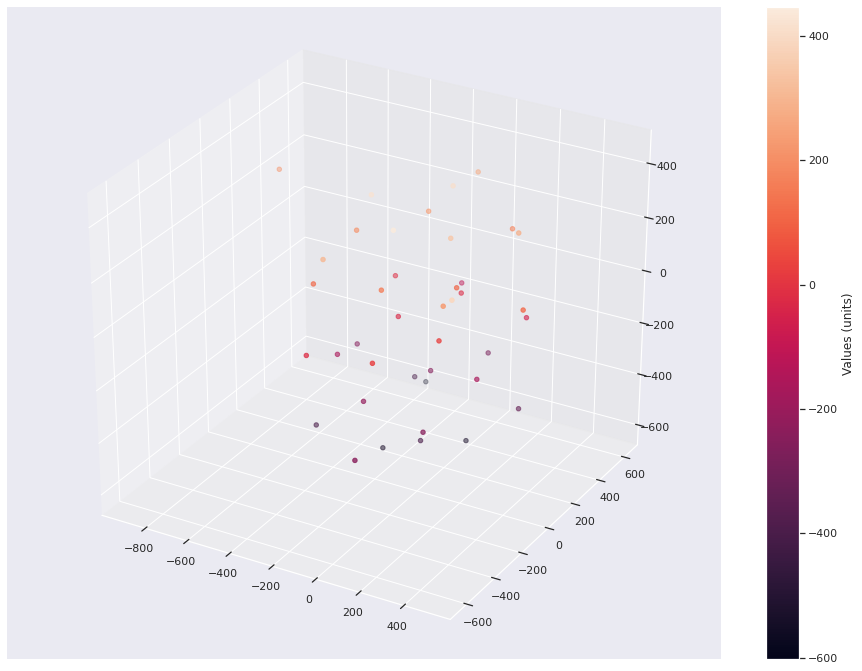

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

pnt3d = ax.scatter(xs, ys, zs, c = zs)
cbar=plt.colorbar(pnt3d)

cbar.set_label("Values (units)")
# ax.plot3D(xs,ys,zs)

plt.savefig('loss_landscape_3d.png')

> We can clearly see the trend going downward denoting the presence of some minima is the loss landscape. (Note we are only looking at one trajectory.)

In [ ]:
wandb.init(entity='authors', project='loss-landscape', id='medium_cnn_trajectory_investigation')
wandb.log({'loss_landscape_2d': wandb.Image('loss_landscape_2d.png')})
wandb.log({'loss_landscape_3d': wandb.Image('loss_landscape_3d.png')})